Three Models tried
===================
Single code using a for loop for
===================================
1) L2 with BN
2) L1 with BN
3) L1 with L2 and with BN

L2 with BN - Optimizer and Losses  used
=========================================
(Weight Decay parameter used for L2)
optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9, dampening = 0, weight_decay = 0 , nesterov = False)

F.nll_loss(y_pred, target)



Accuracy with L2 with BN
============================

Last 4 Epoch ranges from 99.0% to 99.2%

L1 with BN - Optimizer and Losses  used
===========================================

optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

F.nll_loss(y_pred, target) 

PLUS

      lambda_l1 = 0.00001 # Lambda_l1 set here

      for q in model.parameters():

        l1 = l1 + q.abs().sum()

      loss = loss + l1 * lambda_l1

Accuracy with L1 with BN
=======================

Last 2 epoch = 99.2%

Note: with lambda_l1 = 0.1 and 0.01 , accuracies were fluctuating across epoch, so used lambda_l1 = 0.00001

L1 with L2 with BN - Optimizer and Losses  used
===============================================

(Weight Decay parameter used for L2)
optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9, dampening = 0, weight_decay = 0 , nesterov = False)
F.nll_loss(y_pred, target) 

PLUS

      lambda_l1 = 0.00001 # Lambda_l1 set here

      for q in model.parameters():

        l1 = l1 + q.abs().sum()

      loss = loss + l1 * lambda_l1


Accuracy with L1 and L2 with BN
=================================

Note: with lambda_l1 = 0.1 and 0.01 , accuracies were fluctuating across epoch, so used lambda_l1 = 0.00001

Last 4 epochs, test accuracy is around 99.2%


In [ ]:
# Import Libraries

In [50]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
#%matplotlib inline  

## Data Transformations




In [51]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [52]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [53]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [54]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=22, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(22),
            nn.ReLU(),
            
            nn.Dropout(dropout_value)
        ) # output_size = 24

    
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU(),
            
            nn.Dropout(dropout_value)
        ) # output_size = 10

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            
            nn.ReLU(),
            
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
           
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6

       # OUTPUT BLOCK


        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
             nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          
         ) # output_size = 1

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [55]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 22, 24, 24]           3,168
       BatchNorm2d-6           [-1, 22, 24, 24]              44
              ReLU-7           [-1, 22, 24, 24]               0
           Dropout-8           [-1, 22, 24, 24]               0
         MaxPool2d-9           [-1, 22, 12, 12]               0
           Conv2d-10           [-1, 10, 12, 12]             220
      BatchNorm2d-11           [-1, 10, 12, 12]              20
             ReLU-12           [-1, 10, 12, 12]               0
          Dropout-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing



In [66]:
from tqdm import tqdm

ml_type = ['L2_BN','L1_BN', 'L1_L2_BN']

train_losses_L2_BN = []
test_losses_L2_BN = []
train_acc_L2_BN = []
test_acc_L2_BN = []

train_losses_L1_BN = []
test_losses_L1_BN = []
train_acc_L1_BN = []
test_acc_L1_BN = []

train_losses_L1L2_BN = []
test_losses_L1L2_BN = []
train_acc_L1L2_BN = []
test_acc_L1L2_BN = []

optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9, dampening = 0, weight_decay = 0 , nesterov = False)

def train(model, device, train_loader, epoch, dl_type):
  
  if dl_type == 'L2_BN': # For L2 Regularization - Used weight_decay = 0
    
    optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9, dampening = 0, weight_decay = 0 , nesterov = False)

  elif  dl_type == 'L1_BN': # Weight decay is not used for L1 HOWEVER Loss will be different for L1
    optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

  elif  dl_type == 'L1_L2_BN': 
    optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9, dampening = 0, weight_decay = 0 , nesterov = False)
  
  else:
    p = 1

  model.train()
  #pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    if dl_type == 'L2_BN':
      train_losses_L2_BN.append(loss)
    elif  dl_type == 'L1_BN':
      l1 = 0
      lambda_l1 = 0.00001 # Lambda_l1 set here
      for q in model.parameters():
        l1 = l1 + q.abs().sum()
      
      loss = loss + l1 * lambda_l1  # For L1 Model , Loss is nll loss but l1 regularization loss
      train_losses_L1_BN.append(loss)

    elif  dl_type == 'L1_L2_BN':
      l1 = 0
      lambda_l1 = 0.00001 # Lambda_l1 set here
      for q in model.parameters():
        l1 = l1 + q.abs().sum()
      
      loss = loss + l1 * lambda_l1  # For L1 Model , Loss is nll loss but l1 regularization loss
      train_losses_L1L2_BN.append(loss)
    else:
      p =1

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    #pbar.set_description(desc= f'Model Type ={dl_type} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    
    if dl_type == 'L2_BN':
      train_acc_L2_BN.append(100*correct/processed)
    elif dl_type == 'L1_BN':
      train_acc_L1_BN.append(100*correct/processed)
    elif dl_type == 'L1_L2_BN':
      train_acc_L1L2_BN.append(100*correct/processed)
    else:
      p =1
  print('Model ', dl_type, ' epoch ', epoch , ' Training Accuracy', 100*correct/processed ) 

def test(model, device, test_loader,dl_type):
    #optimizer.zero_grad()
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            l1 = 0
            lambda_l1 = 0.01
              
            test_loss += F.nll_loss(output, target, reduction='sum').item()   # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)

    if dl_type == 'L2_BN':
      test_losses_L2_BN.append(test_loss)
    elif  dl_type == 'L1_BN':
      
      test_losses_L1_BN.append(test_loss)

    elif  dl_type == 'L1_L2_BN':
      
      test_losses_L1L2_BN.append(test_loss)
    else:
      p = 1

    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    if dl_type == 'L2_BN':
      test_acc_L2_BN.append(100. * correct / len(test_loader.dataset))
    elif dl_type == 'L1_BN':
      test_acc_L1_BN.append(100. * correct / len(test_loader.dataset))
    elif dl_type == 'L1_L2_BN':
      test_acc_L1L2_BN.append(100. * correct / len(test_loader.dataset))
      p =1

In [68]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)

EPOCHS = 25

for mdl_no in range(len(ml_type)):
  print('Model ' , ml_type[mdl_no] )
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, epoch,ml_type[mdl_no]) # ml_type is a list stores the names of different models
    test(model, device, test_loader,ml_type[mdl_no])

Model  L2_BN
EPOCH: 0
Model  L2_BN  epoch  0  Training Accuracy 89.66166666666666

Test set:  Average loss: 0.0932, Accuracy: 9707/10000 (97.07%)

EPOCH: 1
Model  L2_BN  epoch  1  Training Accuracy 97.06

Test set:  Average loss: 0.0726, Accuracy: 9775/10000 (97.75%)

EPOCH: 2
Model  L2_BN  epoch  2  Training Accuracy 97.615

Test set:  Average loss: 0.0518, Accuracy: 9839/10000 (98.39%)

EPOCH: 3
Model  L2_BN  epoch  3  Training Accuracy 97.83166666666666

Test set:  Average loss: 0.0530, Accuracy: 9843/10000 (98.43%)

EPOCH: 4
Model  L2_BN  epoch  4  Training Accuracy 97.99833333333333

Test set:  Average loss: 0.0492, Accuracy: 9866/10000 (98.66%)

EPOCH: 5
Model  L2_BN  epoch  5  Training Accuracy 98.23666666666666

Test set:  Average loss: 0.0367, Accuracy: 9893/10000 (98.93%)

EPOCH: 6
Model  L2_BN  epoch  6  Training Accuracy 98.36166666666666

Test set:  Average loss: 0.0456, Accuracy: 9871/10000 (98.71%)

EPOCH: 7
Model  L2_BN  epoch  7  Training Accuracy 98.405

Test set:  Av

Epoch 25


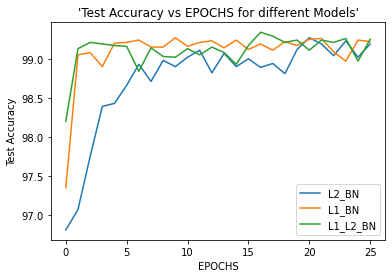

In [69]:

plt.title("'Test Accuracy vs EPOCHS for different Models'") 
plt.xlabel('EPOCHS') 
plt.ylabel('Test Accuracy')
print('Epoch ' + str(EPOCHS))
plt.plot(test_acc_L2_BN,label = 'L2_BN')
plt.plot(test_acc_L1_BN,label = 'L1_BN')
plt.plot(test_acc_L1L2_BN,label = 'L1_L2_BN')
plt.legend()
plt.show() 

Epoch 25
[96.81, 97.07, 97.75, 98.39, 98.43, 98.66, 98.93, 98.71, 98.98, 98.9, 99.02, 99.11, 98.82, 99.07, 98.9, 99.0, 98.89, 98.94, 98.81, 99.12, 99.27, 99.19, 99.04, 99.23, 99.02, 99.19]


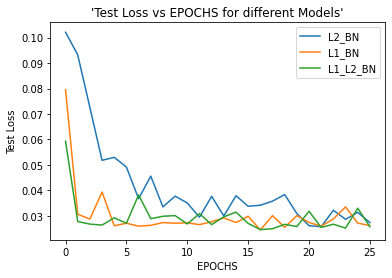

In [70]:
plt.title("'Test Loss vs EPOCHS for different Models'") 
plt.xlabel('EPOCHS') 
plt.ylabel('Test Loss')
print('Epoch ' + str(EPOCHS))
print(test_acc_L2_BN)
plt.plot(test_losses_L2_BN,label = 'L2_BN')
plt.plot(test_losses_L1_BN,label = 'L1_BN')
plt.plot(test_losses_L1L2_BN,label = 'L1_L2_BN')
plt.legend()

plt.show() 